## Import libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Functions

In [91]:
def calculate_glucose_stats(segment, feature):
    """Calculate comprehensive statistics for glucose data"""
    stats = {}
    
    # Basic statistics
    stats['mean'] = segment[feature].mean()
    stats['median'] = segment[feature].median() 
    stats['std'] = np.std(segment[feature], ddof=1)
    stats['var'] = np.var(segment[feature], ddof=1)
    stats['range'] = segment[feature].max() - segment[feature].min()
    stats['mad'] = np.mean(np.abs(segment[feature] - segment[feature].mean()))
    stats['cv'] = stats['std'] / stats['mean'] if stats['mean'] != 0 else np.nan # coefficient of variation
    
    # Time series specific
    differences = np.diff(segment[feature])
    stats['rmssd'] = np.sqrt(np.mean(differences ** 2))
    returns = np.log(segment[feature] / segment[feature].shift(1)).dropna()
    stats['volatility'] = np.std(returns, ddof=1)
    
    # Additional statistics
    stats['skewness'] = segment[feature].skew()
    stats['kurtosis'] = segment[feature].kurtosis()
    stats['iqr'] = segment[feature].quantile(0.75) - segment[feature].quantile(0.25)
    stats['entropy'] = -np.sum(np.square(segment[feature]/segment[feature].sum()) * 
                              np.log(segment[feature]/segment[feature].sum()))
    
    # Rate of change statistics
    stats['mean_abs_change'] = np.mean(np.abs(differences))
    stats['max_change'] = np.max(np.abs(differences))
    
    # Percentiles
    stats['percentile_10'] = np.percentile(segment[feature], 10)
    stats['percentile_90'] = np.percentile(segment[feature], 90)
    
    return stats

def get_patient_stats(patient, prediction_horizon):
    glucose_df = pd.read_csv(f'datasets/gpt4o_{prediction_horizon}.csv')
    glucose_df = glucose_df[glucose_df['patient'] == int(patient[2])]
    glucose_df['date'] = pd.to_datetime(glucose_df['datetime']).dt.date

    segments_grouped = {str(date): segment for date, segment in glucose_df.groupby('date')}
    features = ['glucose']
    results = {'Date': list(segments_grouped.keys())}
    
    for feature in features:
        for segment_date, segment in segments_grouped.items():
            stats = calculate_glucose_stats(segment, feature)
            for stat_name, stat_value in stats.items():
                if f'{feature}_{stat_name}' not in results:
                    results[f'{feature}_{stat_name}'] = []
                results[f'{feature}_{stat_name}'].append(stat_value)

    results_df_grouped = pd.DataFrame(results)
    return results_df_grouped

## Combine patient data

In [92]:
results = pd.read_csv('results.csv')
results = results[results['Prediction Horizon'] == 6]

In [95]:
patients = ['001', '002', '004', '006', '007', '008']
patient_stats = pd.DataFrame()
for patient in patients:
    individual_patient_stats = get_patient_stats(patient, 6)
    individual_patient_stats['Patient'] = patient
    patient_stats = pd.concat([patient_stats, individual_patient_stats])

mean_patient_stats = patient_stats.drop(columns=['Date']).groupby('Patient').mean().reset_index()
mean_patient_stats['RMSE_gpt4o'] = results[results['Approach'] == 'gpt4o']['RMSE'].values
mean_patient_stats['RMSE_nollm'] = results[results['Approach'] == 'nollm']['RMSE'].values

def get_food_data_stats(patient):
    food_data = pd.read_csv(f'food_data/gpt4o/{patient}.csv')
    stats = {}
    
    # Calculate various statistics for each nutrient
    for nutrient in ['simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']:
        stats[f'Mean_{nutrient}'] = food_data[nutrient].mean()
        stats[f'Median_{nutrient}'] = food_data[nutrient].median()
        stats[f'Std_{nutrient}'] = food_data[nutrient].std()
        stats[f'Min_{nutrient}'] = food_data[nutrient].min()
        stats[f'Max_{nutrient}'] = food_data[nutrient].max()
        stats[f'Q1_{nutrient}'] = food_data[nutrient].quantile(0.25)
        stats[f'Q3_{nutrient}'] = food_data[nutrient].quantile(0.75)
        stats[f'IQR_{nutrient}'] = stats[f'Q3_{nutrient}'] - stats[f'Q1_{nutrient}']
        stats[f'CV_{nutrient}'] = stats[f'Std_{nutrient}'] / stats[f'Mean_{nutrient}'] * 100  # Coefficient of variation
        stats[f'Skew_{nutrient}'] = stats[f'Mean_{nutrient}'] / stats[f'Std_{nutrient}']
        stats[f'Kurt_{nutrient}'] = stats[f'Mean_{nutrient}'] / stats[f'Std_{nutrient}'] ** 4
    return pd.DataFrame([stats])

patient_food_data_stats = pd.DataFrame()
for patient in patients:
    patient_stats = get_food_data_stats(patient)
    patient_food_data_stats = pd.concat([patient_food_data_stats, patient_stats])

# Add all statistics to mean_patient_stats
for nutrient in ['simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']:
    for stat in ['Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3', 'IQR', 'CV']:
        col_name = f'{stat}_{nutrient}'
        mean_patient_stats[col_name] = patient_food_data_stats[col_name].values

In [122]:
# Get correlations for both RMSE_gpt4o and RMSE_diff
mean_patient_stats['RMSE_diff'] = mean_patient_stats['RMSE_nollm'] - mean_patient_stats['RMSE_gpt4o']
correlations_gpt4o = mean_patient_stats.corr()['RMSE_gpt4o']
correlations_diff = mean_patient_stats.corr()['RMSE_diff']

# Get top 15 features for each metric initially
top_15_gpt4o = correlations_gpt4o.abs().sort_values(ascending=False).head(15)
top_15_diff = correlations_diff.abs().sort_values(ascending=False).head(15)

# Remove the RMSE columns themselves and get top 10 from remaining features
top_10_gpt4o = top_15_gpt4o[~top_15_gpt4o.index.isin(['RMSE_gpt4o', 'RMSE_nollm', 'RMSE_diff'])].head(10)
top_10_diff = top_15_diff[~top_15_diff.index.isin(['RMSE_gpt4o', 'RMSE_nollm', 'RMSE_diff'])].head(10)

# Create lists for table data
features_gpt4o = list(top_10_gpt4o.index)
corr_gpt4o = [correlations_gpt4o[feat] for feat in features_gpt4o]
features_diff = list(top_10_diff.index)
corr_diff = [correlations_diff[feat] for feat in features_diff]

# Generate LaTeX table with styling
latex_table = """\\begin{table}[h]
\\centering
\\rowcolors{2}{gray!15}{gray!5}  % Alternate row colors
\\begin{tabular}{|l|r|l|r|}
\\hline
\\rowcolor{gray!25}  % Header row color
\\multicolumn{2}{|c|}{\\textbf{Correlations with RMSE gpt4o}} & \\multicolumn{2}{c|}{\\textbf{Correlations with RMSE diff}} \\\\
\\hline
\\rowcolor{gray!25}  % Header row color
\\textbf{Feature} & \\textbf{Correlation} & \\textbf{Feature} & \\textbf{Correlation} \\\\
\\hline
"""

for i in range(10):
    # Replace underscores with spaces and capitalize feature names
    feature_gpt4o = ' '.join(word.capitalize() for word in features_gpt4o[i].split('_'))
    feature_diff = ' '.join(word.capitalize() for word in features_diff[i].split('_'))
    latex_table += f"{feature_gpt4o} & {corr_gpt4o[i]:.3f} & {feature_diff} & {corr_diff[i]:.3f} \\\\\n"

latex_table += """\\hline
\\end{tabular}
\\caption{\\textbf{Top 10 Feature Correlations with RMSE gpt4o and RMSE diff}}
\\label{tab:correlations}
\\end{table}"""

# Save the LaTeX table to a file
with open('latex_tables/feature_correlations.tex', 'w') as f:
    f.write(latex_table)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


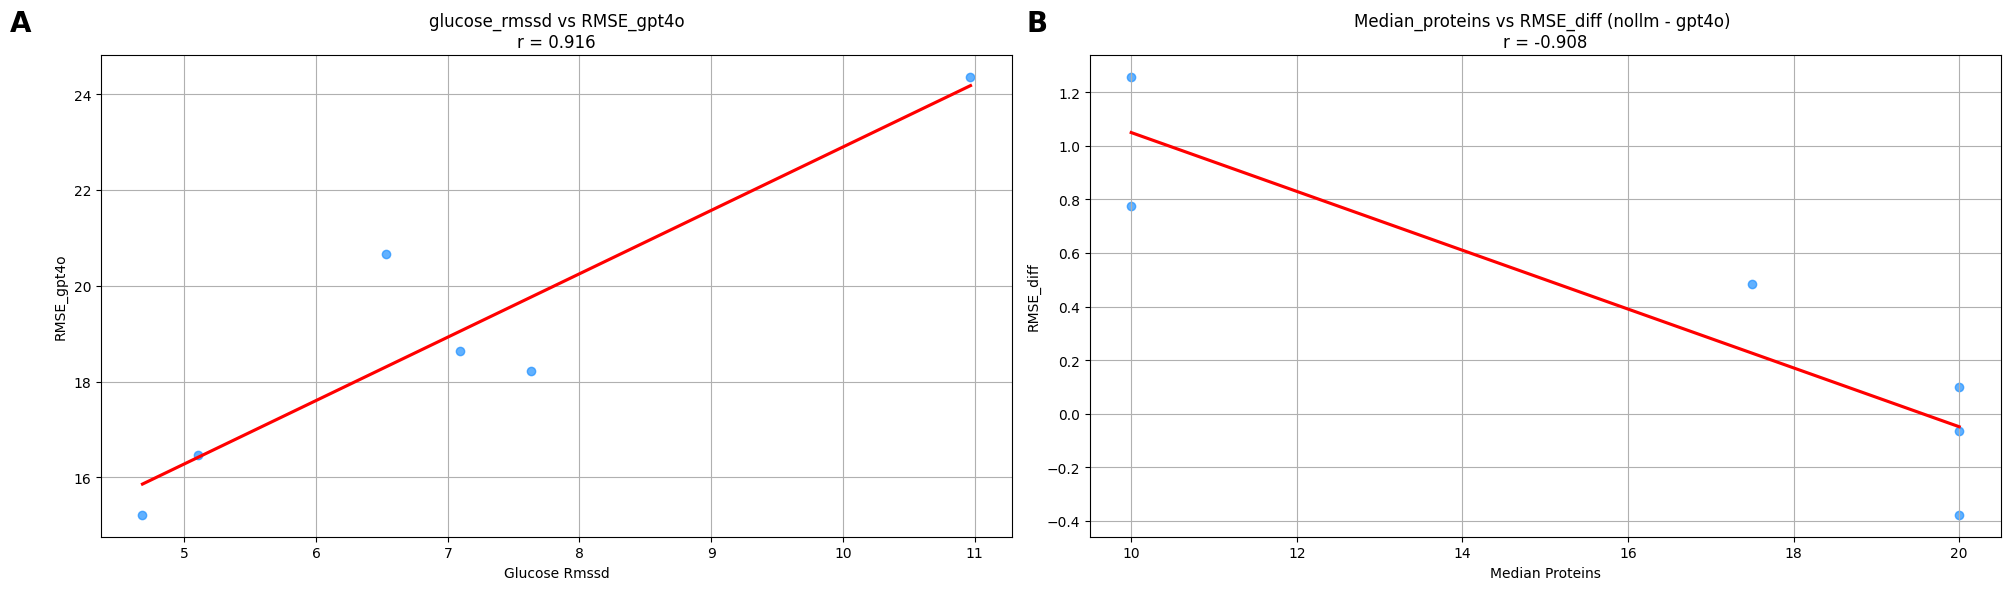

In [123]:
top_feature_diff = top_10_diff.sort_values(ascending=False).index[1]  # Skip 'RMSE_diff' itself
top_feature_gpt4o = top_10_gpt4o.sort_values(ascending=False).index[1]  # Skip 'RMSE_gpt4o' itself

# Calculate correlation coefficients
corr_gpt4o = mean_patient_stats[top_feature_gpt4o].corr(mean_patient_stats['RMSE_gpt4o'])
corr_diff = mean_patient_stats[top_feature_diff].corr(mean_patient_stats['RMSE_diff'])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First subplot for RMSE_gpt4o
ax1.scatter(mean_patient_stats[top_feature_gpt4o], mean_patient_stats['RMSE_gpt4o'], color='dodgerblue', alpha=0.7)
sns.regplot(x=mean_patient_stats[top_feature_gpt4o], y=mean_patient_stats['RMSE_gpt4o'],
            scatter=False, ax=ax1, 
            line_kws={'color': 'red'},
            ci=None,  # 95% confidence interval
            color='gray')  # This will make confidence interval gray
ax1.set_title(f'{top_feature_gpt4o} vs RMSE_gpt4o\nr = {corr_gpt4o:.3f}')
ax1.set_xlabel(top_feature_gpt4o.replace('_', ' ').title())
ax1.set_ylabel('RMSE_gpt4o')
ax1.grid(True)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold')

# Second subplot for RMSE_diff
ax2.scatter(mean_patient_stats[top_feature_diff], mean_patient_stats['RMSE_diff'], color='dodgerblue', alpha=0.7)
sns.regplot(x=mean_patient_stats[top_feature_diff], y=mean_patient_stats['RMSE_diff'],
            scatter=False, ax=ax2,
            line_kws={'color': 'red'},
            ci=None,  # No confidence interval
            color='gray')
ax2.set_title(f'{top_feature_diff} vs RMSE_diff (nollm - gpt4o) \nr = {corr_diff:.3f}')
ax2.set_xlabel(top_feature_diff.replace('_', ' ').title())
ax2.set_ylabel('RMSE_diff')
ax2.grid(True)
ax2.text(-0.07, 1.05, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold')

plt.tight_layout()

# Save with explicit RGB colorspace and no transparency
plt.savefig('paper_images/correlation_plots.eps', format='eps', transparent=False)
plt.show()
plt.close()